# OllamaFunctions

This notebook shows how to use an experimental wrapper around Ollama that gives it [tool calling capabilities](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling).

Note that more powerful and capable models will perform better with complex schema and/or multiple functions. The examples below use llama3 and phi3 models.
For a complete list of supported models and model variants, see the [Ollama model library](https://ollama.ai/library).

:::warning

This is an experimental wrapper that attempts to bolt-on tool calling support to models that do not natively support it. Use with caution.

:::
## Overview

### Integration details

|                                                                Class                                                                | Package | Local | Serializable | JS support | Package downloads | Package latest |
|:-----------------------------------------------------------------------------------------------------------------------------------:|:-------:|:-----:|:------------:|:----------:|:-----------------:|:--------------:|
| [OllamaFunctions](https://api.python.langchain.com/en/latest/llms/langchain_experimental.llms.ollama_function.OllamaFunctions.html) | [langchain-experimental](https://api.python.langchain.com/en/latest/openai_api_reference.html) | ✅ | ❌ | ❌ | ![PyPI - Downloads](https://img.shields.io/pypi/dm/langchain-experimental?style=flat-square&label=%20) | ![PyPI - Version](https://img.shields.io/pypi/v/langchain-experimental?style=flat-square&label=%20) |

### Model features

| [Tool calling](/docs/how_to/tool_calling/) | [Structured output](/docs/how_to/structured_output/) | JSON mode | Image input | Audio input | Video input | [Token-level streaming](/docs/how_to/chat_streaming/) | Native async | [Token usage](/docs/how_to/chat_token_usage_tracking/) | [Logprobs](/docs/how_to/logprobs/) |
| :---: | :---: | :---: | :---: |  :---: | :---: | :---: | :---: | :---: | :---: |
| ✅ | ✅ | ✅ | ✅ | ❌ | ❌ | ❌ | ✅ | ❌ | ❌ |

## Setup

To access `OllamaFunctions` you will need to install `langchain-experimental` integration package.
Follow [these instructions](https://github.com/jmorganca/ollama) to set up and run a local Ollama instance as well as download and serve [supported models](https://ollama.com/library).

### Credentials

Credentials support is not present at this time.

### Installation

The `OllamaFunctions` class lives in the `langchain-experimental` package:


In [ ]:
%pip install -qU langchain-experimental

## Instantiation

`OllamaFunctions` takes the same init parameters as `ChatOllama`. 

In order to use tool calling, you must also specify `format="json"`.

In [6]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

llm = OllamaFunctions(model="phi3")

## Invocation

In [3]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'adore programmer.", id='run-94815fcf-ae11-438a-ba3f-00819328b5cd-0')

In [4]:
ai_msg.content

"J'adore programmer."

## Chaining

We can [chain](https://python.langchain.com/v0.2/docs/how_to/sequence/) our model with a prompt template like so:

In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input_language": "English",
        "output_language": "German",
        "input": "I love programming.",
    }
)

AIMessage(content='Programmieren ist sehr verrückt! Es freut mich, dass Sie auf Programmierung so positiv eingestellt sind.', id='run-ee99be5e-4d48-4ab6-b602-35415f0bdbde-0')

## Tool Calling

### OllamaFunctions.bind_tools()

With `OllamaFunctions.bind_tools`, we can easily pass in Pydantic classes, dict schemas, LangChain tools, or even functions as tools to the model. Under the hood these are converted to a tool definition schemas, which looks like:

In [7]:
from langchain_core.pydantic_v1 import BaseModel, Field


class GetWeather(BaseModel):
    """Get the current weather in a given location"""

    location: str = Field(..., description="The city and state, e.g. San Francisco, CA")


llm_with_tools = llm.bind_tools([GetWeather])

In [8]:
ai_msg = llm_with_tools.invoke(
    "what is the weather like in San Francisco",
)
ai_msg

AIMessage(content='', id='run-b9769435-ec6a-4cb8-8545-5a5035fc19bd-0', tool_calls=[{'name': 'GetWeather', 'args': {'location': 'San Francisco, CA'}, 'id': 'call_064c4e1cb27e4adb9e4e7ed60362ecc9'}])

### AIMessage.tool_calls

Notice that the AIMessage has a `tool_calls` attribute. This contains in a standardized `ToolCall` format that is model-provider agnostic.

In [10]:
ai_msg.tool_calls

[{'name': 'GetWeather',
  'args': {'location': 'San Francisco, CA'},
  'id': 'call_064c4e1cb27e4adb9e4e7ed60362ecc9'}]

For more on binding tools and tool call outputs, head to the [tool calling](docs/how_to/function_calling) docs.


## Structured Output

With `OllamaFunctions.with_structured_output()` you can specify a Pydantic class or a json schema to define the structure of the output you desire from the llm.


In [11]:
from typing import Optional

from langchain_core.pydantic_v1 import BaseModel, Field


class Joke(BaseModel):
    """Joke to tell user."""

    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")
    rating: Optional[int] = Field(description="How funny the joke is, from 1 to 10")


structured_llm = llm.with_structured_output(Joke)
structured_llm.invoke("Tell me a joke about cats")

Joke(setup='Why was the cat sitting on the computer?', punchline='Because it wanted to be online!', rating=8)

## OllamaFunctions and Agents

`OllamaFunctions` currently only supports creating agents using `LangGraph`.  
An example of a simple tool calling agent built with LangGraph is shared below.  
Building agents using the now legacy [`AgentExecutor`](https://python.langchain.com/v0.2/docs/how_to/agent_executor/) is not supported.

### LangGraph Agent With Tool Calling

Below is an example of a simple Tool Calling LangGraph Agent using OllamaFunctions

### Install dependencies

In [ ]:
%%capture
%pip install langchain-core==0.2.9 langchain-community==0.2.5 langchain-experimental==0.0.61 langgraph==0.0.69 duckduckgo-search==6.1.7 httpx==0.27.0

### Imports

In [1]:
from typing import List

from IPython.display import Image, display
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.tools import tool
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt import ToolNode

### Define Tools

Here we have created 4 custom tools and used an existing tool for our toolset.

In [2]:
@tool
def multiply(a: int, b: int) -> int:
    """Tool to multiply two numbers"""
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Tool to add two numbers"""
    return a + b


@tool
def call_miracle(request: str) -> str:
    """Tool to call miracle"""
    return f"You asked for {request}, but I can't do that"


@tool
def grant_wish(wish: str) -> str:
    """Tool to grant wish"""
    return f"You asked for {wish}. Your wish is my command!"


tools = [multiply, add, call_miracle, grant_wish, DuckDuckGoSearchRun(max_results=2)]

# tool_node will be used as a node within the LangGraph agent
tool_node = ToolNode(tools)

### Initialize LLM and bind tools

You can use any tool calling capable LLM along with a model that offers good JSON support.  
We have use `OllamaFunctions` with the `phi3` model here.  
The complete list of natively supported [LLMs with tool calling can be found here](https://python.langchain.com/v0.1/docs/integrations/chat/)  

We initialize `llm` and add tools description on it by calling `bind_tools` function on it.  
This doesn't change `llm` itself, but returns a new LLM object that is aware of the tools specifications which we store as `llm_with_tools`.  

We will use `llm_with_tools` for any tool aware LLM calls and use `llm` for other, non tool related LLM calls.

In [3]:
llm = OllamaFunctions(model="phi3", format="json", temperature=0)
llm_with_tools = llm.bind_tools(tools)

### MessageGraph

[MessageGraph](https://python.langchain.com/v0.1/docs/integrations/chat/) is a simple `LangGraph` state type where every node receives a list of messages as input and returns one or more messages as output.  

This should be suitable for may use cases where you only need to track messages as part of the graph state.

In [4]:
builder = MessageGraph()

### Add nodes to graph

Graph nodes have a name and take a callables as a second argument which are runnables that get invoked and are passed the entire state object.  

Since `MessageGraph` is essentially just a collection of messages, you can use LLMs as the callable parameter.  

* `oracle`: We pass `llm_with_tools` as this node with identify which tool needs to be called to complete the current request.
* `tools`: We pass `tool_node` as the callable. If the last message in the state is an `AIMessage` with `tool_calls`, this node will use that information to call the approprtate tool from our toolset with the parameters specified in `tool_calls`.
* `llm`: We pass `llm` as the callable. This node will take all the messages generated thus far and use that context to generate a new message. The expected outcome is the model's interpretation of the results from the tool run within the context of the initial question that was asked of the agent.

In [5]:
builder.add_node("oracle", llm_with_tools)
builder.add_node("tools", tool_node)
builder.add_node("llm", llm)

### Connect agent nodes with edges

This will be a simple linear graph.

* `oracle` is the entry point.
* `tools` node will be called after `oracle`.
* `llm` node will be called after `tools`.
* graph ends with the execution of `llm` node.

In [6]:
builder.add_edge("oracle", "tools")
builder.add_edge("tools", "llm")
builder.add_edge("llm", END)
builder.set_entry_point("oracle")
graph = builder.compile()

### Visualizing the graph agent

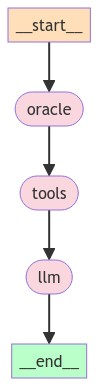

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

Utility functions to pretty print messages

In [ ]:
def trim_content(content: str) -> str:
    if len(content) < 200:
        return content
    else:
        return content[:200] + "..."


def pretty_print(message: BaseMessage):
    print(f"type: {message.type}", end="")
    if isinstance(message, AIMessage) and message.tool_calls:
        print(f", tool_calls: {message.tool_calls}", end="")
    elif isinstance(message, ToolMessage):
        print(f", name: {message.name}", end="")
    if message.content:
        print(f", content: {trim_content(message.content)}", end="")
    print("\n")


def pretty_print_messages(messages: List[BaseMessage]):
    [pretty_print(message) for message in messages]

### Running the Agent

Testing `add` custom tool

In [ ]:
result = graph.invoke(("human", "What is the sum of 2 and 3?"))
pretty_print_messages(result)

Testing `multiply` custom tool

In [ ]:
result = graph.invoke(("human", "What is 523 x 412?"))
pretty_print_messages(result)

Testing `call_miracle` custom tool

In [ ]:
result = graph.invoke(("human", "I need a miracle. I need it to rain tomorrow."))
pretty_print_messages(result)

Testing `grant_wish` custom tool

In [ ]:
result = graph.invoke(("human", "I wish for world peace."))
pretty_print_messages(result)

Testing `duckduckgo_search` tool `DuckDuckGoSearchRun`

In [ ]:
result = graph.invoke(("human", "What is tomorrows weather in Austin, TX?"))
pretty_print_messages(result)

## API reference

For detailed documentation of all ToolCallingLLM features and configurations head to the API reference: https://api.python.langchain.com/en/latest/llms/langchain_experimental.llms.ollama_functions.OllamaFunctions.html
